# Fast Computation for Multi-objective Optimization

In the [previous tutorial](./tutorial_multi.ipynb), we independently modeled each objective function using Gaussian process and directly maximized the Pareto hypervolume. However, this approach becomes computationally expensive when the number of objective functions increases.

In this tutorial, we will learn how to speed up multi-objective optimization by unifying multiple objective functions into a single objective function, and performing Bayesian optimization on that unified objective.

## Unification of Multi-objective Optimization

Let the $i$-th data point (feature vector) be $\vec{x}_i$, and its objective values be $\vec{y}_i = (y_{i,1}, y_{i,2}, \dots, y_{i,p})$.
We construct a new unified objective $z_i$ from $\vec{y}_i$. We model the function from $\vec{x}_i$ to $z_i$, $z_i = g(\vec{x}_i)$, by Gaussian process regression and perform Bayesian optimization on it.

In the current version of PHYSBO, two methods are provided to construct $z_i$ from $\vec{y}_i$: the Non-dominated Sorting (NDS) method and the ParEGO method.

### Non-dominated Sorting Method

#### Definition

Non-dominated Sorting (NDS) is a method where the training data $\vec{y}_i$ are ranked using non-dominated sorting, and a new objective function is created based on these ranks. The rank is recursively defined as follows:

1. Points that are on the Pareto front of the entire training dataset are assigned a rank of $r_i = 1$.
2. After removing the points with rank $r_i = 1$, the points on the next Pareto front are assigned a rank of $r_i = 2$.
3. Similarly, after removing all points with ranks $r_i = 1,2,\dots,k-1$, the points on the next Pareto front are assigned a rank of $r_i = k$.
4. This process is repeated until the maximum rank $r_\text{max}$ is reached. Any remaining points are assigned $r_i = \infty$.

Based on the rank $r_i$, the new objective function $z_i$ is defined as follows and is maximized:

$$
z_i = \frac{1}{r_i}
$$

#### How to Use in PHYSBO

In PHYSBO, the NDS method is implemented as the `physbo.search.unify.NDS` class.

``` python
unify_method = physbo.search.unify.NDS(rank_max=10)
```

Any points with ranks above `rank_max` are handled as $z_i = 0$.

### ParEGO Method

#### Definition

The ParEGO method converts multi-objective optimization into single-objective optimization by taking a weighted sum and a weighted maximum of the objective function values.
Let the weights for the objectives be $\vec{w} = (w_1, w_2, \dots, w_p)$, and let the coefficients for sum and max be $\rho_\text{sum}$ and $\rho_\text{max}$, respectively. Then, the new unified objective function is defined as:

$$
z_i = \rho_\text{sum} \sum_{j} w_j y_{i,j} + \rho_\text{max} \max_{j} w_j y_{i,j}
$$

#### Usage in PHYSBO

In PHYSBO, the ParEGO method is implemented as the `physbo.search.unify.ParEGO` class.

``` python
unify_method = physbo.search.unify.ParEGO(weight_sum=0.05, weight_max=1.0, weights=None, weights_discrete=0)
```

`weight_sum` and `weight_max` correspond to $\rho_\text{sum}$ and $\rho_\text{max}$, respectively.  
`weights` specifies the weight vector $\vec{w}$.

- The weights $\vec{w}$ are automatically normalized so that $\sum_{j} w_j = 1$.
- If `weights = None`, weights are randomly generated at each Bayesian optimization step.
  - If `weights_discrete` is set to an integer $s>0$, each weight is generated as $w_j = \frac{a_j}{s}$.
    - Here $a_j$ is an integer from $0$ to $s$, and $\sum_{j} a_j = s$.
  - If $s=0$, weights are sampled uniformly at random from $[0,1)$ and then normalized so that their sum is 1.

Also, for each objective $j$, $y_{i,j}$ is normalized to the range $[-1, 0]$ using the minimum and maximum values in the training data.

## Tutorial

### Preparations

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import physbo
%matplotlib inline

seed = 12345
num_random_search = 10
num_bayes_search = 40

#### Test Functions

In this tutorial, we continue to use VLMOP2, which is a benchmark function for multi-objective optimization.
PHYSBO provides several multi-objective benchmark functions, including VLMOP2, under `physbo.test_functions.multi_objective`.

In [2]:
sim_fn = physbo.test_functions.multi_objective.VLMOP2(dim=2)

#### Preparing Candidate Data for Search

The `sim_fn` object contains `min_X` and `max_X`, which specify the minimum and maximum values of the search space.
Using these, you can generate a grid of candidate points with `physbo.search.utility.make_grid`.

In [3]:
test_X = physbo.search.utility.make_grid(min_X=sim_fn.min_X, max_X=sim_fn.max_X, num_X=101)

#### simulator

In [4]:
simu = physbo.search.utility.Simulator(test_X=test_X, test_function=sim_fn)

#### HVPI

As a comparison, we perform Bayesian optimization using HVPI.

In [5]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_HVPI = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, score='HVPI', interval=10, is_disp=False)
time_HVPI = time.time() - time_start
time_HVPI

4.200511932373047

Text(0.5, 1.0, 'HVPI')

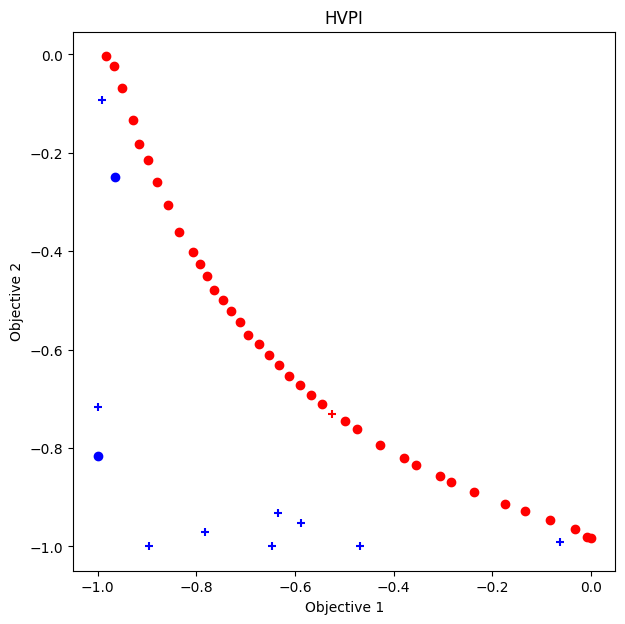

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_HVPI, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_HVPI, ax=ax, steps_begin=num_random_search)
ax.set_title("HVPI")

In [7]:
VID_HVPI = res_HVPI.pareto.volume_in_dominance([-1,-1],[0,0])
VID_HVPI

np.float64(0.3285497837573861)

### Bayesian Optimization with Unified Objective

Use the `physbo.search.discrete_unified.Policy` class as `Policy` class.

As with other `Policy` classes, you can create initial data using `random_search` etc., and perform Bayesian optimization with the `bayes_search` method.
The difference from other `Policy` classes is as follows.

#### Unification of Objective Function

The algorithm used for unification is specified by the `unify_method` argument of the `bayes_search` method.
PHYSBO provides `physbo.search.unify.ParEGO` and `physbo.search.unify.NDS`.

#### Acquisition Function

The acquisition function is the same as that for single-objective optimization.

- PI (Probability of Improvement)
- EI (Expected Improvement)
- TS (Thompson Sampling)


### NDS

In [8]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.NDS(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_NDS = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_NDS = time.time() - time_start
time_NDS

1.7535040378570557

#### Plotting Pareto Front

Text(0.5, 1.0, 'NDS')

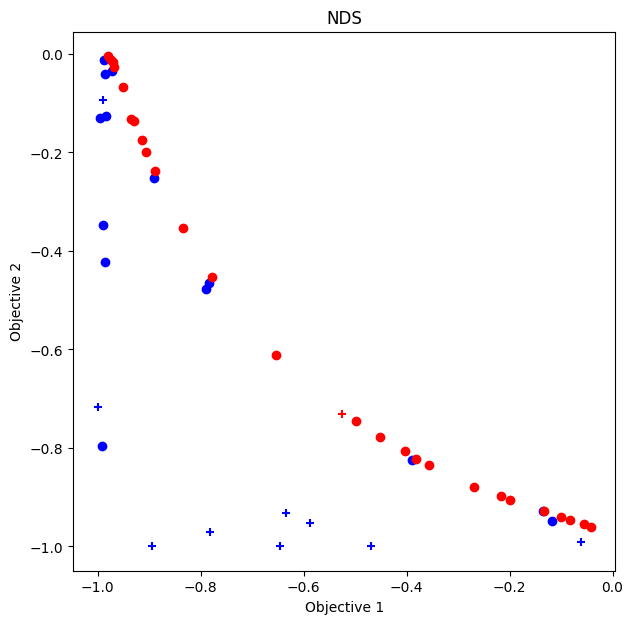

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_NDS, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_NDS, ax=ax, steps_begin=num_random_search)
ax.set_title("NDS")

#### Volume of Dominance Region

In [10]:
VID_NDS = res_NDS.pareto.volume_in_dominance([-1,-1],[0,0])
VID_NDS

np.float64(0.30923409715730354)

### ParEGO

In [11]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.ParEGO(num_objectives=2)

res_random = policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_ParEGO = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_ParEGO = time.time() - time_start
time_ParEGO

1.7327749729156494

#### Plotting Pareto Front

Text(0.5, 1.0, 'ParEGO')

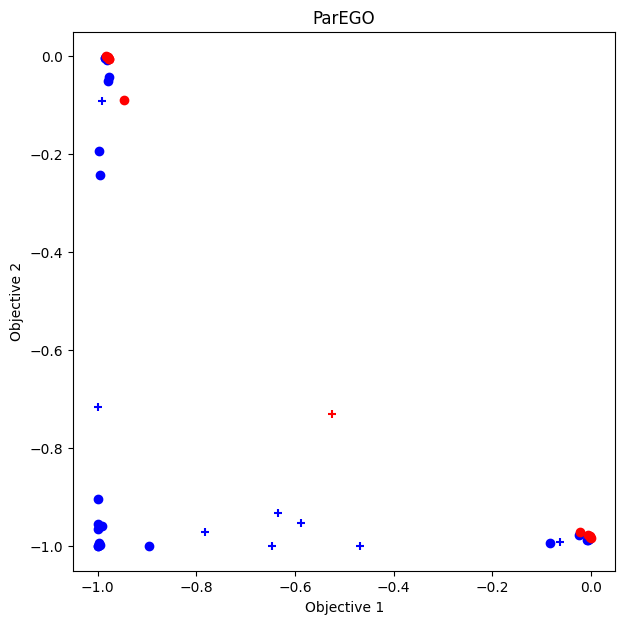

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_ParEGO, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_ParEGO, ax=ax, steps_begin=num_random_search)
ax.set_title("ParEGO")

#### Volume of Dominance Region

In [13]:
VID_ParEGO = res_ParEGO.pareto.volume_in_dominance([-1,-1],[0,0])
VID_ParEGO

np.float64(0.18004551161609372)

### Comparison of Results

In [14]:
# make table
df = pd.DataFrame({
    "Algorithm": ["NDS", "ParEGO", "HVPI"],
    "Computation Time": [time_NDS, time_ParEGO, time_HVPI],
    "Volume of Dominance Region": [VID_NDS, VID_ParEGO, VID_HVPI]
})
df


Algorithm  Computation Time  Volume of Dominance Region
0       NDS          1.753504                    0.309234
1    ParEGO          1.732775                    0.180046
2      HVPI          4.200512                    0.328550

NDS achieves a comparable result in terms of the volume of the dominance region to HVPI, but with a shorter computation time.

On the other hand, while ParEGO has the shortest computation time, the volume of the dominance region it achieves is smaller.

Depending on the optimization problem, the algorithm that produces the best results may vary as seen below.

### Another Benchmark Function

We now perform Bayesian optimization using the Kita-Yabumoto-Mori-Nishikawa function:

$$
\begin{cases}
f_1(x, y) = -x^2 + y^2 \\
f_2(x, y) = 0.5x + y + 1 \\
\end{cases}
$$

Furthermore, $x$ and $y$ have the following constraints:

$$
\begin{cases}
g_1(x, y) = 6.5 - x/6 - y \ge 0 \\
g_2(x, y) = 7.5 - x/2 - y \ge 0 \\
g_3(x, y) = 30 - 5x - y \ge 0 \\
\end{cases}
$$


Kita, H., Yabumoto, Y., Mori, N., Nishikawa, Y. (1996). Multi-objective optimization by means of the thermodynamical genetic algorithm. In: Voigt, HM., Ebeling, W., Rechenberg, I., Schwefel, HP. (eds) Parallel Problem Solving from Nature — PPSN IV. PPSN 1996. Lecture Notes in Computer Science, vol 1141. Springer, Berlin, Heidelberg. https://doi.org/10.1007/3-540-61723-X_1014



In [15]:
fn_KYMN = physbo.test_functions.multi_objective.KitaYabumotoMoriNishikawa()
test_X_KYMN = physbo.search.utility.make_grid(min_X=fn_KYMN.min_X, max_X=fn_KYMN.max_X, num_X=101, constraint=fn_KYMN.constraint)
simu_KYMN = physbo.search.utility.Simulator(test_X=test_X_KYMN, test_function=fn_KYMN)

#### HVPI

Text(0.5, 1.0, 'HVPI')

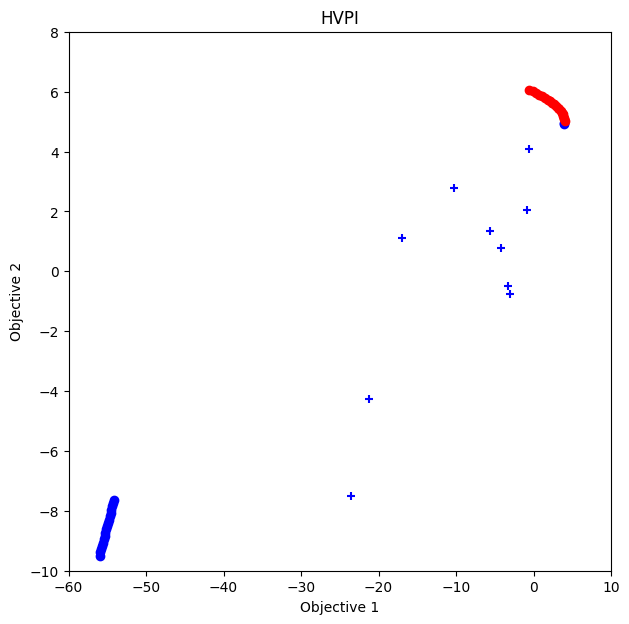

In [16]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_HVPI = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, score='HVPI', interval=10, is_disp=False)
time_KYMN_HVPI = time.time() - time_start
VID_KYMN_HVPI = res_KYMN_HVPI.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_HVPI
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_HVPI, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_HVPI, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("HVPI")

#### ParEGO

Text(0.5, 1.0, 'ParEGO')

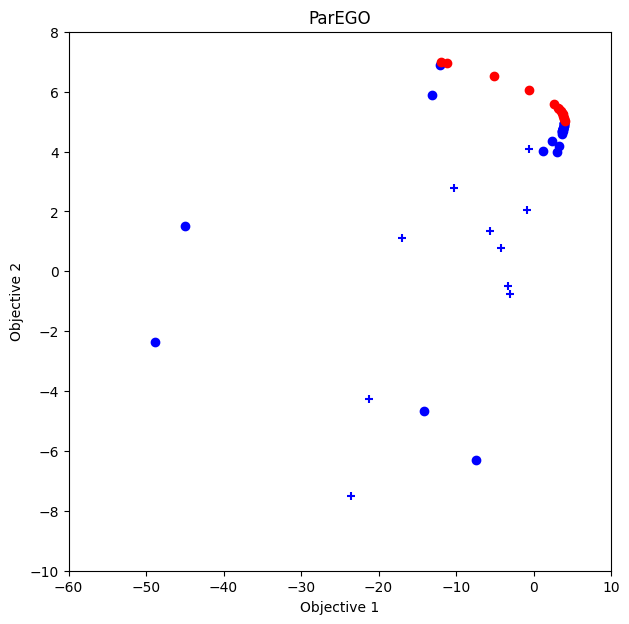

In [17]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.ParEGO(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_ParEGO = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_KYMN_ParEGO = time.time() - time_start
VID_KYMN_ParEGO = res_KYMN_ParEGO.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_ParEGO
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_ParEGO, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_ParEGO, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("ParEGO")


#### NDS

Text(0.5, 1.0, 'NDS')

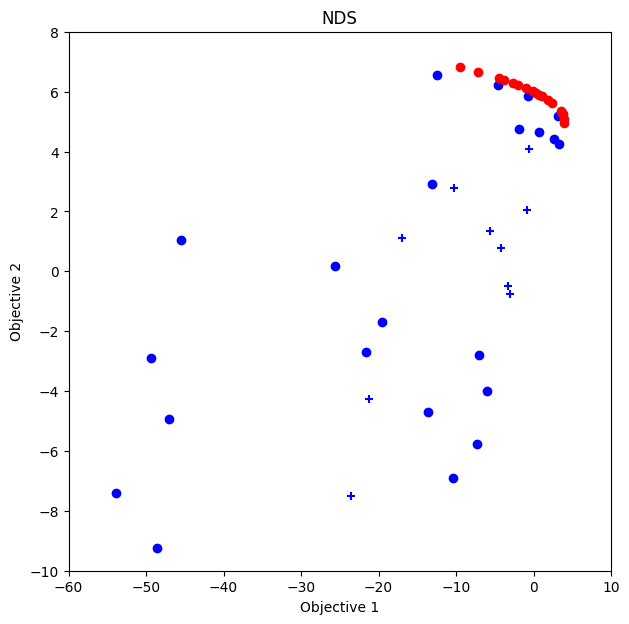

In [18]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.NDS(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_NDS = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_KYMN_NDS = time.time() - time_start
VID_KYMN_NDS = res_KYMN_NDS.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_NDS
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_NDS, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_NDS, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("NDS")


#### Comparison of Results

In [19]:
pd.DataFrame({
    "Algorithm": ["NDS", "ParEGO", "HVPI"],
    "Computation Time": [time_KYMN_NDS, time_KYMN_ParEGO, time_KYMN_HVPI],
    "Volume of Dominance Region": [VID_KYMN_NDS, VID_KYMN_ParEGO, VID_KYMN_HVPI]
})


Algorithm  Computation Time  Volume of Dominance Region
0       NDS          1.740349                  970.781427
1    ParEGO          1.728085                  975.909589
2      HVPI          3.897053                  932.139351

In this case, ParEGO works better than NDS and HVPI.